In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt


AUTOTUNE = tf.data.experimental.AUTOTUNE

root_dir = pathlib.Path.cwd()
imgs_dir = root_dir.joinpath('imgs')

all_image_paths = list(imgs_dir.glob('*.jpg'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = sorted(all_image_paths)
image_count = len(all_image_paths)

  image = tf.image.decode_jpeg(image, channels=1)
  image = tf.image.resize(image, [28, 28])
  image /= 255.0
  return image

img1 = load_and_preprocess_image(all_image_paths[1])

all_image_labels = [0, 1, 7]
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


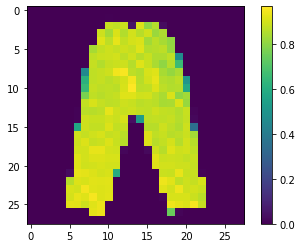

In [79]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image)
  image = tf.image.rgb_to_grayscale(image)
  image = tf.image.resize(image, [28, 28])
  image /= 255.0
  image = 1 - image
  return image

img1 = load_and_preprocess_image(all_image_paths[1])
# print(img1.numpy())

plt.figure()
plt.imshow(img1)
plt.colorbar()
plt.grid(False)
plt.show()


# image = tf.io.read_file(all_image_paths[1])
# #将图片转换为数组
# image = image.numpy()
# # image = image.astype(dtype='uint8')
# #转为黑白
# image = tf.image.rgb_to_grayscale(image)
# #降维
# image = tf.squeeze(image,2)
# plt.imshow(image)



In [ ]:

path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
print(image_label_ds)

In [ ]:


BATCH_SIZE = 32

ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# 当模型在训练的时候，`prefetch` 使数据集在后台取得 batch。
ds = ds.prefetch(buffer_size=AUTOTUNE)

ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)


def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)
image_batch, label_batch = next(iter(keras_ds))


feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)


# mobile_net = tf.keras.applications.MobileNetV2(input_shape=(28, 28, 1), include_top=False)
# mobile_net.trainable=False

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import subprocess
from tensorflow.keras.preprocessing.image import load_img, img_to_array


fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(test_images[0])
print(type(test_images))
print(type(test_images[0]))

In [83]:

img1 = load_and_preprocess_image(all_image_paths[2])
img1 = img1.numpy()

import json
import requests

# data = json.dumps({"instances": image_ds[0:3].tolist()})
data = json.dumps({"instances": img1.tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

headers = {"content-type": "application/json"}
resp = requests.post('http://127.0.0.1:8501/v1/models/fashion_model:predict', data=data, headers=headers)
print(resp.text)

Data: {"instances": [[[0.0], [0.0], [0.0], [0.0], [0.0], ... , [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]}
{
    "predictions": [[-4.0972352, -8.12490368, -8.45447254, -7.7095089, -6.36014652, -0.645658612, -6.88962507, -0.378783524, -3.24148512, -5.10464621]
    ]
}
